# Iterative Sylvester Solvers
## Gradient Based Method
To solve $AX + XB = C$, rewrite as:
- $AX = C-XB$
- $XB = C-AX$

Then define two recursive sequences:
- $X_k^{(1)} = X_{k-1}^{(1)} + \kappa A^T (C-AX_{k-1}^{(1)} - X_{k-1}^{(1)}B)$
- $X_k^{(2)} = X_{k-1}^{(2)} + \kappa (C-AX_{k-1}^{(2)} - X_{k-1}^{(2)}B)B^T$

where $\kappa$ is the relative step size. The $k^{\text{th}}$ approximate solution is then defined as the average of the above two iterative procedures
- $X_k = \frac{X_k^{(1)} + X_k^{(2)}}{2}$

To compute this an appropriate initial approximate solution $X_0$ is needed. The method converges if 
- $0 < \kappa < \frac{2}{\lambda_{\text{max}}(AA^T) + \lambda_{\text{max}}(B^TB)} $

where $\lambda_{\text{max}}(AA^T)$ is the max eigenvalue of $AA^T$

### For TU+UT=F
Recursive sequences: (noting that $T^T = T$)
- $U_k^{(1)} = U_{k-1}^{(1)} + \kappa T(F-TU_{k-1}^{(1)} - U_{k-1}^{(1)}T)$
- $U_k^{(2)} = U_{k-1}^{(2)} + \kappa (F-TU_{k-1}^{(2)} - U_{k-1}^{(2)}T)T$

$k^{\text{th}}$ approximate solution $U_k$ is:
- $U_k = \frac{U_k^{(1)} + U_k^{(2)}}{2}$

Solution converges if:
- $0 < \kappa < \frac{1}{\lambda_{\text{max}}(T^2)} $


6682
[[0.00810108 0.01554585 0.02173119 0.026156   0.02846181 0.02846181
  0.026156   0.02173119 0.01554585 0.00810108]
 [0.01554585 0.02983227 0.04170185 0.050193   0.05461781 0.05461781
  0.050193   0.04170185 0.02983227 0.01554585]
 [0.02173119 0.04170185 0.05829408 0.07016366 0.076349   0.076349
  0.07016366 0.05829408 0.04170185 0.02173119]
 [0.026156   0.050193   0.07016366 0.08445008 0.09189485 0.09189485
  0.08445008 0.07016366 0.050193   0.026156  ]
 [0.02846181 0.05461781 0.076349   0.09189485 0.09999593 0.09999593
  0.09189485 0.076349   0.05461781 0.02846181]
 [0.02846181 0.05461781 0.076349   0.09189485 0.09999593 0.09999593
  0.09189485 0.076349   0.05461781 0.02846181]
 [0.026156   0.050193   0.07016366 0.08445008 0.09189485 0.09189485
  0.08445008 0.07016366 0.050193   0.026156  ]
 [0.02173119 0.04170185 0.05829408 0.07016366 0.076349   0.076349
  0.07016366 0.05829408 0.04170185 0.02173119]
 [0.01554585 0.02983227 0.04170185 0.050193   0.05461781 0.05461781
  0.050193 

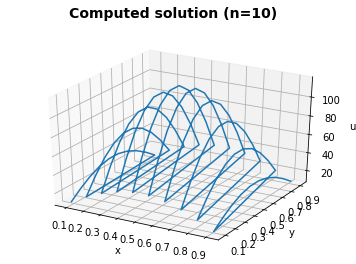

In [1]:
#Import necessary modules
import numpy as np
import scipy as sp
from scipy.sparse import diags
from scipy.linalg import solve_sylvester #computes solution to AX + XB = Q
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
import pylab

#Define parameters
n = 10 #number of internal nodes in each direction (number of unknowns)
h = 1/(n+1) #step size

U = np.zeros([n,n])

#Define convergence tol, intial guess and iteration step
tol = np.empty([n,n])
for i in range(0,n):
    for j in range(0,n):
        tol[i][j]=0.1
        U[i][j] = 0
        
#Set U_1 & U_2 equal to initial guess
U_1 = np.zeros([n,n])
U_2 = np.zeros([n,n])

#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(h, 1-h, n)
y = np.linspace(h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

#Define F 
F = 2 * np.pi**2 * np.sin(np.pi*X) * np.sin(np.pi*Y)    
        
#Define tridiagonal matrix T
diagonals = [[-2],[1],[1]]
T = np.multiply((-1), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())

#Calculate eigenvalues to check method converges
eigvals = np.linalg.eig(np.matmul(T,T))[0]

#Get maximum eigenvalue
eig_max = np.max(eigvals)

# print('eigvals: ', eigvals)
# print('eig_max: ', eig_max)

k = 0.06

# plt.figure(0)
# plt.suptitle('Structure of T^2', fontsize=14, fontweight='bold')
# plt.imshow(np.matmul(T,T))

if(k<1/eig_max):
    num_steps = 0
    while (np.absolute(np.matmul(T,U) + np.matmul(U,T) - F) > tol).any() == True:
        U_1 = U_1 + k*np.matmul(T,(F - np.matmul(T, U_1) - np.matmul(U_1,T)))
        U_2 = U_2 + k*np.matmul((F - np.matmul(T,U_2) - np.matmul(U_2,T)), T)

        U = (U_1+U_2)/2
        num_steps += 1
        
    print(num_steps)
    print(np.absolute(np.matmul(T,U) + np.matmul(U,T) - F) )    

    #Plot computed solution
    plt.figure(1)
    plt.suptitle('Computed solution (n=' + str(n) +')', fontsize=14, fontweight='bold')
    ax = plt.axes(projection='3d')
    xline = np.reshape(X, -1)
    yline = np.reshape(Y, -1)
    zline = np.reshape(U, -1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.plot3D(xline, yline, zline)

else:
    print('Iterative step size too large. Method will not converge.\nk must be smaller than: ', (1/eig_max))

    



